In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, ClassifierMixin 
import seaborn as sb

# Comparison of Regressors for Abalone Age Prediction
In this assignment, the objective is to compare the performance of different regressors on the Abalone dataset. What is the best algorithm for the dataset?

In [3]:
abalone_data = pd.read_csv('data/abalone.data')
abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Introduction
In this project, the goal is to analyze a dataset to predict the age of abalones. The focus is on exploring the relationships between various aspects of an abalone's shape and weight and the target variable, the number of rings on its shell, which indicates its age. By developing a model trained on this data, we aim to predict an abalone's age more efficiently and accurately, simplifying the process and providing valuable insights into the characteristics that influence age estimation.
    
features:  
The dataset contains 8 features, each providing distinct information about the abalone's size and weight. All the features are continuous variables, capturing measurements that can be used to analyze and predict the abalone's age.
  
Target:  
The target variable is an integer value, representing the number of rings the abalone has. By adding 1.5 to this value, we obtain the abalone's age in years. This makes the task a regression problem, as the goal is to predict a continuous numerical outcome based on the features.
    
According to the UCI repository, any missing values in the dataset have been removed, ensuring data completeness. Additionally, the ranges of the continuous values have been scaled.    
https://archive.ics.uci.edu/dataset/1/abalone
  
    
The steps I will follow to identify the best model include:
        1. Analyzing dataset:  Gain a deeper understanding of the characteristics of the features and the target variable.  
        2. preprocessing of data: Create alternative datasets based on the insights gained from the analysis  
        3. Splitting the data: Dividing the dataset into training, validation, and testing sets  
        4. Hyperparameter Tuning: I will be using nested grid search to find the best parameters for each model  
        5. Model evaluation: evaluating using accuracy, precision, recall, the f-measure and roc-auc to conclude which is the best model.  
   
By following these steps, we can gain valuable insights into the dataset, refine it for modeling, and ultimately identify which model performs better. This process will not only help understand the relationships between the features and the target variable but also provide a reliable model for predicting abalone age.

# encoding the categorical feature
this will make it easier to use the explorary functions

In [4]:
label_encoder = LabelEncoder()

abalone_data['M'] = label_encoder.fit_transform(abalone_data['M'])

abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Exploratory analysis of the dataset
After analyzing the distribution of the features, most appear to follow a normal distribution, except for the column M, which represents gender. This suggests that models well-suited for this dataset include:
  
DecisionTreeRegressor: Handles non-linear relationships and categorical features like gender effectively.  
LinearRegressor: Works well with normally distributed data and can capture linear relationships between features and the target variable.  
SVR (Support Vector Regressor): Effective for both linear and non-linear relationships, especially with scaled data, which is ideal for this dataset.  
These models are good starting points for predicting the abalone's age based on its characteristics.  

array([[<Axes: title={'center': 'M'}>, <Axes: title={'center': '0.455'}>,
        <Axes: title={'center': '0.365'}>],
       [<Axes: title={'center': '0.095'}>,
        <Axes: title={'center': '0.514'}>,
        <Axes: title={'center': '0.2245'}>],
       [<Axes: title={'center': '0.101'}>,
        <Axes: title={'center': '0.15'}>, <Axes: title={'center': '15'}>]],
      dtype=object)

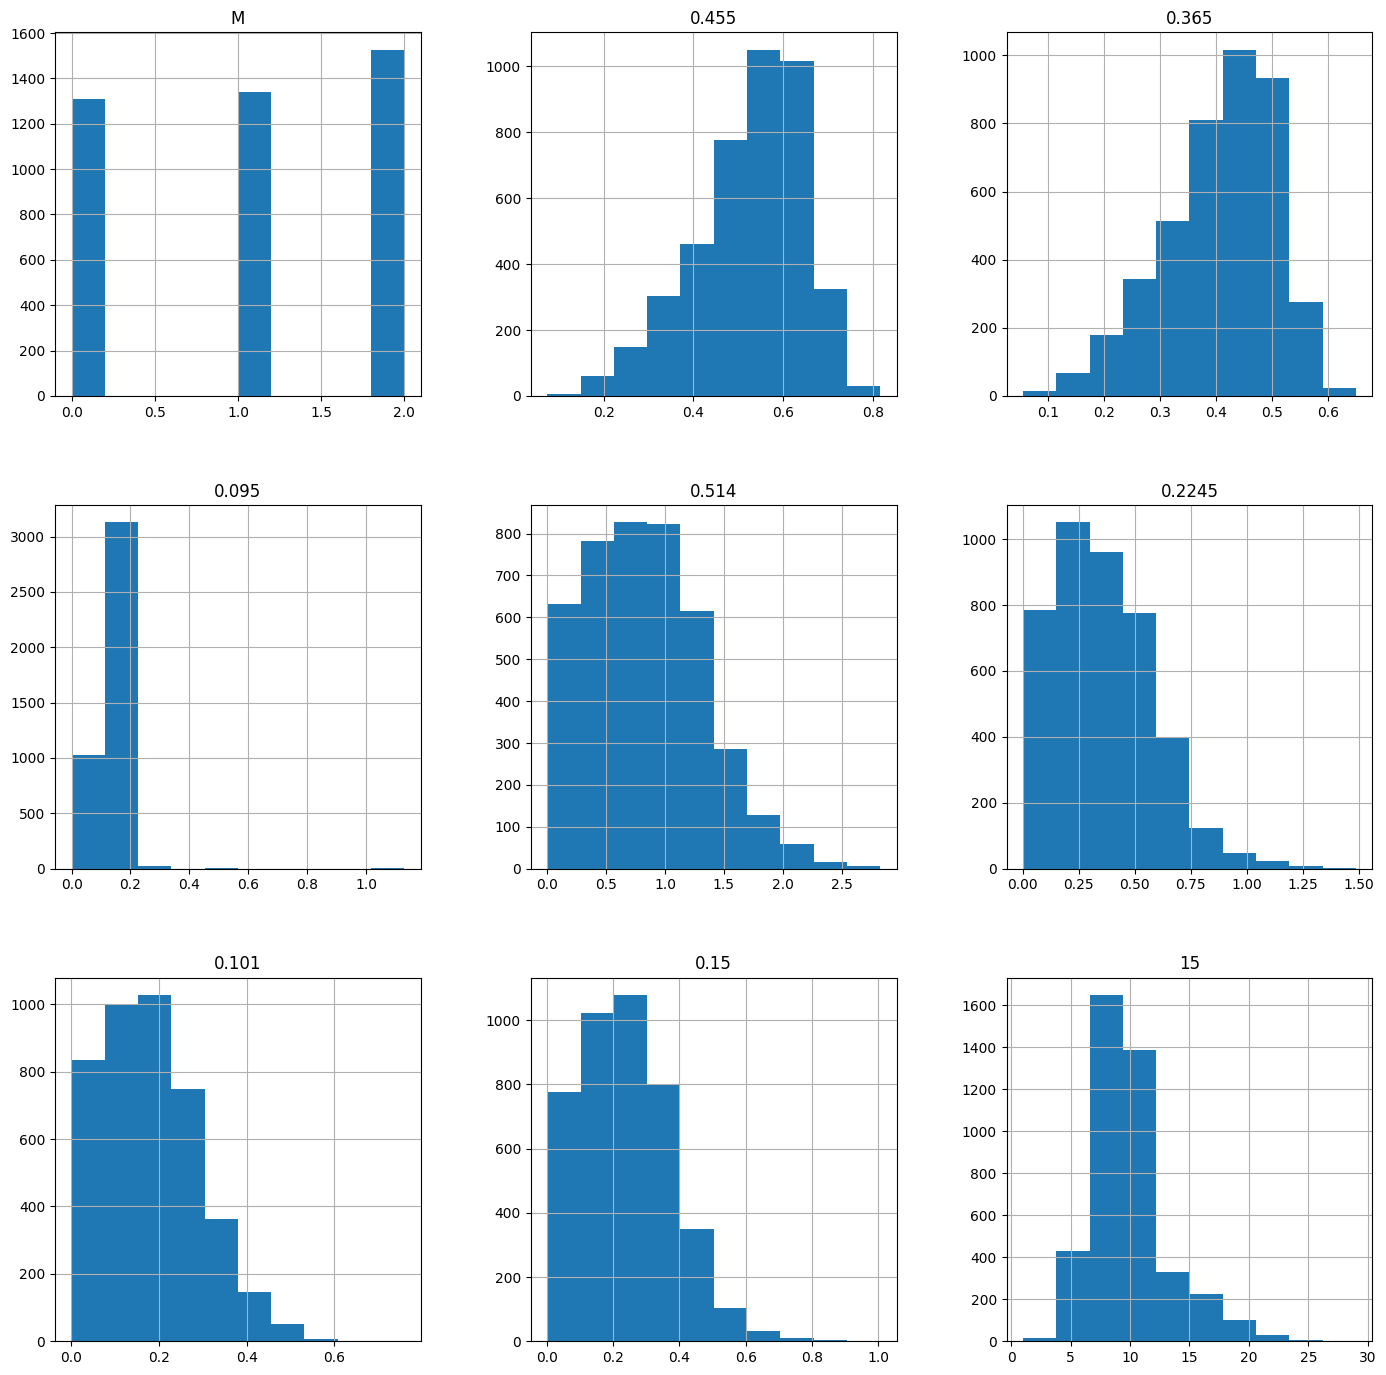

In [17]:
abalone_data.hist(figsize=(17, 17))

# Correlation
it looks like the features of the dataset are heavily correlated, beside the M feature and the target. 

In [6]:
abalone_corr = abalone_data.corr()
abalone_corr.style.background_gradient(cmap='coolwarm')

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
M,1.000000,-0.035915,-0.038762,-0.041796,-0.021219,-0.001205,-0.031873,-0.034686,-0.035076
0.455,-0.035915,1.000000,0.986813,0.827552,0.925255,0.897905,0.903010,0.897697,0.557123
0.365,-0.038762,0.986813,1.000000,0.833705,0.925452,0.893159,0.899726,0.905328,0.575005
0.095,-0.041796,0.827552,0.833705,1.000000,0.819209,0.774957,0.798293,0.817326,0.558109
0.514,-0.021219,0.925255,0.925452,0.819209,1.000000,0.969403,0.966372,0.955351,0.540818
0.2245,-0.001205,0.897905,0.893159,0.774957,0.969403,1.000000,0.931956,0.882606,0.421256
0.101,-0.031873,0.903010,0.899726,0.798293,0.966372,0.931956,1.000000,0.907647,0.504274
0.15,-0.034686,0.897697,0.905328,0.817326,0.955351,0.882606,0.907647,1.000000,0.628031
15,-0.035076,0.557123,0.575005,0.558109,0.540818,0.421256,0.504274,0.628031,1.000000


# Necessary pre-processing of data

# PCA
There were many correlated features, as indicated in the correlation matrix above. Combining all of these columns could result in the loss of important information. Therefore, I am combining columns 1, 2, 4, 5, and 6, as these showed the highest correlations among them. On the other hand, columns 3 and 7 had the highest correlations with the target variable, so it would be better to leave them out of the PCA

seeing how much cumulative variance is retained whith every number of pca. a dimention reduction to 3 will give us a lot of information still.

[0.97980967 0.98987339 0.99726163 0.99954037 1.        ]


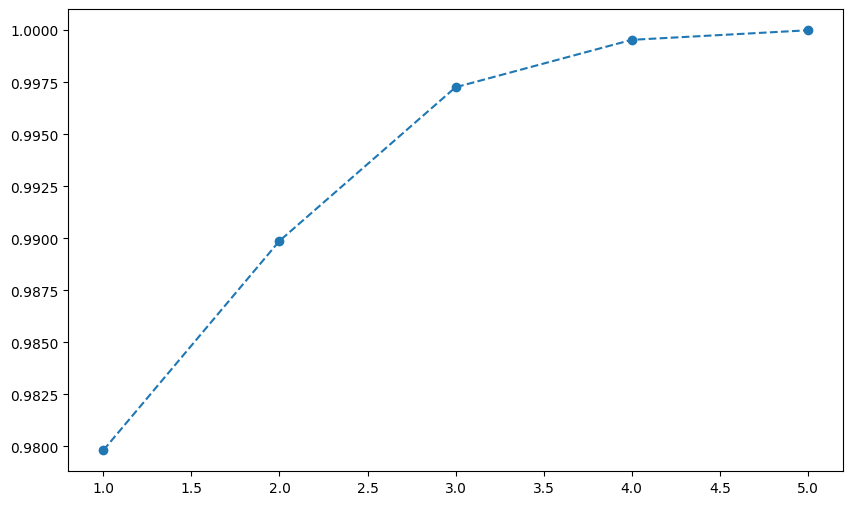

In [77]:
pca = PCA()
number_of_pca = pca.fit_transform(abalone_data.iloc[:, [1, 2, 4, 5, 6]])
number_of_pca

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

In [96]:
pca = ColumnTransformer([
     ("pca", PCA(3), [1,2,4,5,6])], remainder='passthrough')

# pipe to easily access the changes in the data

In [97]:
def pipe_altered_data(model):
    return Pipeline([('pca', pca), ('classifier', model)])

# spliting the data:
I am splitting the data into training-validation and test. The trai_val data will make up 80% of the dataset, while the test data will account for 20%. Since I will be using grid search, the training data will be further divided into training and validation sets at different stages during the grid search process. Once we identify the best model, we can be confident that it is based on the entire training dataset, which helps reduce the risk of overfitting. The train_val data should be the largest section because it needs to be substantial enough to provide sufficient data for training the model, while also allowing for a validation section to monitor the model's progress during training. This is why 80% of the total data is allocated to the train_val set. The test data should also be large enough to effectively evaluate how the model performs on unseen data. Therefore, allocating 20% of the total dataset for testing is typically sufficient.  
  
how the train_val data will be split in nested grid search:  
outer loop(5-cross validation folds):   
    - 80% of the entire dataset is split into five sections  
    - 4/5 (80%) of the train_val data is used for the grid search  
    - 1/5 (20%) of the train_val data is used to evaluate the best model returned from the grid search. which will be unseen data and not used to train the model in the inner loop
inner loop(4-corss validation folds):   
    -In the inner loop, 64% of the entire dataset (which is 80% of the train_val data) is used  for hyperparameter tuning and cross-validation within the grid search process  
    - 3/4 (75%) of the 64% data is used for training the model.
    - 1/4 (25%) of the 64% data is used for validation during the grid search, helping to tune the hyperparameters.  
Since cross-validation is used, the data in the inner and outer loops will be rotated. Each section will be used for both training and validation in different rounds. 

In [98]:
features = abalone_data.drop('15', axis=1)
targets = abalone_data['15']

train_val_features, test_features, train_val_targets, test_targets = train_test_split(features, targets, test_size=0.2)

# hyperparameter tuning to find the best possible classifiers
I will use nested cross-validation for each algorithm to ensure that I find the best combination of hyperparameters. To evaluate performance during the tuning process, I will consider R², absolute error, and mean squared error.

I will test models in two rounds:  
    -Round One: I will test individual models, an ensemble model, and a combination of models to see if combining models can yield better results. I will test with a limited set of parameters for each model and evaluate both altered and unaltered versions of the data.  
   
    -Round Two: I will take the two best models from Round One, along with the dataset that gave the best results, and test them with a wider range of parameters.  
    
This approach allows me to initially test a variety of models without a high runtime, and then focus on fine-tuning the best-performing models that best fit the dataset and produce the most accurate results.

# 

# function to evaluate a model
This will return the results of the model and will be used in the function below.
  
This model is designed to evaluate the age of an abalone. We should aim for the highest possible R^2 value, indicating a good fit between the model and the data. Additionally, we want to minimize the error, so the model should have the lowest possible Mean Squared Error (MSE) to ensure minimal mistakes in predictions.

In [99]:

def evaluate(estimator, X, y):
    predictions = estimator.predict(X)
    return {
        'r2': r2_score(y, predictions), 
        'mean_absolute_error': mean_absolute_error(y, predictions), 
        'mean_squared_error': mean_squared_error(y, predictions)
    }

# Nested grid search model
This is the best way to find the best model. 
this gridsearch will run an outer loop five times with different parts of the train-val data, then split this data again in the inner loop(four times) which is going to do the grid search. The grid search will then split the part of the data it got into train and validate, and return the best model
  
this method will return a list of five models, for each grid search the best model will be added to this list. it will return the cv_results which contains all the information of each loop of the grid search. The method also return the scores, same as the evaluate function
the models will be returned by the best accuracy, precision_weighted, recall_weighted, f1_weighted, roc_auc_ovr_weighted and refitted so the best f1_weighted is returned

In [100]:
def find_best_models(model, dt_params):
    metrics = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=13)
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'r2': [],
        'mean_absolute_error': [],
        'mean_squared_error': []
    }

    for (train_index, test_index) in list(outer_cv.split(train_val_features, train_val_targets)):

        dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='r2',return_train_score=True)
        dt_grid.fit(train_val_features.iloc[train_index], train_val_targets.iloc[train_index])

        cv_results = pd.DataFrame(dt_grid.cv_results_)
        dt_cv_results.append(cv_results)
        dt_estimators.append(dt_grid.best_estimator_)

        evaluation = evaluate(dt_grid, train_val_features.iloc[test_index], train_val_targets.iloc[test_index])
        dt_test_scores['r2'].append(evaluation['r2'])
        dt_test_scores['mean_absolute_error'].append(evaluation['mean_absolute_error'])
        dt_test_scores['mean_squared_error'].append(evaluation['mean_squared_error'])
    return dt_estimators, dt_cv_results, dt_test_scores



# making models and parameter tuning
For the modeling and parameter tuning process, I'll take a two-round approach.
  
Round 1: Broad Testing with a Smaller Parameter Range
In this round, I'll test multiple models with a limited range of parameters. This allows me to quickly evaluate various algorithms without incurring long run times. The focus here is on identifying which models show the most promise based on performance metrics like F1 score and ROC AUC.
  
Round 2: Focused Testing with Extended Parameters
After analyzing the results from Round 1, I'll select the top two models and refine their tuning. For these models, I'll test a wider range of parameters to optimize their performance further. This focused approach ensures a balance between exploration and efficiency, leading to the best-performing model for the task.

# first round of parameter tuning models

# singular models
i will first test singular models first

# decision tree regressor with original dataset
I am testing two important features:  
Criterion: determines how the decision tree decides to split the data at each node, this impacts how the tree learns and splits the data.  
max depth: This i would say is the most important feature, as this for the most part controlls if the model if the model is more complex or general. (overfitting/underfitting)

In [129]:
dr_params = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
    'max_depth': range(4,8)
}
best_models_dr, cv_results, model_scores = find_best_models(DecisionTreeRegressor(), dr_params)

In [130]:
for model in best_models_dr:
    print(model)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=6)
DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
DecisionTreeRegressor(criterion='poisson', max_depth=5)
DecisionTreeRegressor(max_depth=5)
DecisionTreeRegressor(criterion='poisson', max_depth=6)


the best model is DecisionTreeRegressor(criterion='C', max_depth=5). Criterion friedman_mse occurs the same amount of times as poisson, so i just chose friedman_mse. max depth 5 is most occuring, or 6 which is a number close. 

# decision tree regressor with altered dataset

In [132]:
dr_params = {
    'classifier__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
    'classifier__max_depth': range(4,8)
}
best_models_dr_pipe1, cv_results, model_scores = find_best_models(pipe_altered_data(DecisionTreeRegressor()), dr_params)

In [134]:
for model in best_models_dr_pipe1:
    print(model)

Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', DecisionTreeRegressor(max_depth=4))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', DecisionTreeRegressor(max_depth=4))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier',
                 DecisionTreeRegressor(criterion='poisson', max_depth=5))])
Pipeline(steps=[('pca',
                 ColumnTransform

the best model is DecisionTreeRegressor(criterion='poisson', max_depth=4), these parameters are most occuring

# linear regressor with normal dataset
i am using the ElasticNet linear regressor as it has more parameters to tune:  
alpha: decides how close the model is to the data
l1_ratio: controls the balance between Lasso (L1) for feature selection and Ridge (L2) for shrinking coefficients

In [135]:
lr_params = {
    'alpha': [0.001, 0.01, 0.1, 1], 
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}
best_models_lr, cv_results, model_scores = find_best_models(ElasticNet(), lr_params)

the best model is ElasticNet(alpha=0.001, l1_ratio=0.9) most times

In [137]:
for model in best_models_lr:
    print(model)

ElasticNet(alpha=0.001, l1_ratio=0.9)
ElasticNet(alpha=0.001, l1_ratio=0.9)
ElasticNet(alpha=0.001, l1_ratio=0.7)
ElasticNet(alpha=0.001, l1_ratio=0.9)
ElasticNet(alpha=0.001, l1_ratio=0.7)


# linear regressor with altered dataset

In [138]:
lr_params = {
    'classifier__alpha': [0.001, 0.01, 0.1, 1], 
    'classifier__l1_ratio': [0.1, 0.5, 0.7, 0.9]
}
best_models_lr_pipe, cv_results, model_scores = find_best_models(pipe_altered_data(ElasticNet()), lr_params)

In [140]:
for model in best_models_lr_pipe:
    print(model)

Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=0.9))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=0.7))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=0.7))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
 

the best model is ElasticNet(alpha=0.001, l1_ratio=0.7)

# SVR model with original dataset
the parameters i am tuning are:  
kernel: Specifies the type of kernel that is used in the algortihm
degress: spesicies the dregree of the polynomial kernel

In [141]:
svr_params = {
    'kernel': ['linear', 'poly', 'rbf'], 
    'degree': [1,3,5,]
}
best_models_svr, cv_results, model_scores = find_best_models(SVR(), svr_params)

In [143]:
print(best_models_svr)

[SVR(degree=1), SVR(degree=1), SVR(degree=1), SVR(degree=1), SVR(degree=1)]


the best model is SVR(degree=1)

# SVR with altered dataset

In [144]:
svr_params = {
    'classifier__kernel': ['linear', 'poly', 'rbf'], 
    'classifier__degree': [1,3,5,]
}
best_models_svr_pipe, cv_results, model_scores = find_best_models(pipe_altered_data(SVR()), svr_params)

the best model is SVR(degree=1)

In [145]:
for model in best_models_svr_pipe:
    print(model)

Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', SVR(degree=1))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', SVR(degree=1))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', SVR(degree=1))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components

# evaluation from the first round with singular models:

In [146]:
print("decision tree regressor with original data: ")
decision_tree_best = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_best, test_features, test_targets))
print("decision tree regressor with altered data: ")
decision_tree_pipe_best = pipe_altered_data(DecisionTreeRegressor(criterion='poisson', max_depth=4)).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_pipe_best, test_features, test_targets))

print()

print("Linear regressor elasticNet with original data: ")
elasticnet_best = ElasticNet(alpha=0.001, l1_ratio=0.9).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_best, test_features, test_targets))
print("Linear regressor elasticNet with altered data: ")
elasticnet_pipe_best = pipe_altered_data(ElasticNet(alpha=0.001, l1_ratio=0.7)).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_pipe_best, test_features, test_targets))

print()

print("SVR model with original data: ")
svr_best = SVR(degree=1).fit(train_val_features, train_val_targets)
print(evaluate(svr_best, test_features, test_targets))
print("SVR model with altered data: ")
svr_pipe_best = pipe_altered_data(SVR(degree=1)).fit(train_val_features, train_val_targets)
print(evaluate(svr_pipe_best, test_features, test_targets))


decision tree regressor with original data: 
{'r2': 0.5230868709904672, 'mean_absolute_error': 1.6767491767480593, 'mean_squared_error': 5.399134477931786}
decision tree regressor with altered data: 
{'r2': 0.5510711540605264, 'mean_absolute_error': 1.621677557363106, 'mean_squared_error': 5.08232435387932}

Linear regressor elasticNet with original data: 
{'r2': 0.5565516351305013, 'mean_absolute_error': 1.6590450246508879, 'mean_squared_error': 5.020279816833323}
Linear regressor elasticNet with altered data: 
{'r2': 0.5416330854377216, 'mean_absolute_error': 1.6972730141421384, 'mean_squared_error': 5.189172747447981}

SVR model with original data: 
{'r2': 0.5161315274441074, 'mean_absolute_error': 1.5986385070542348, 'mean_squared_error': 5.477875935993554}
SVR model with altered data: 
{'r2': 0.5059539260456112, 'mean_absolute_error': 1.6121290488754856, 'mean_squared_error': 5.593096581580289}


# ensambeled method

# random forest regressor with original data

In [148]:
rfr_params = {
    'n_estimators': [80, 90, 100]
}
best_models_rfr, cv_results, model_scores = find_best_models(RandomForestRegressor(), rfr_params)

In [149]:
for model in best_models_rfr:
    print(model)

RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor(n_estimators=80)
RandomForestRegressor()
RandomForestRegressor(n_estimators=90)


the best model is RandomForestRegressor(), which is the most occuring

# random forest regressor with altered data
i am testing the n_estimators parameter here, it determines how complex or general the model will become

In [151]:
rfr_params = {
    'classifier__n_estimators': [80, 90, 100]
}
best_models_rfr_pipe, cv_results, model_scores = find_best_models(pipe_altered_data(RandomForestRegressor()), rfr_params)

In [152]:
for model in best_models_rfr_pipe:
    print(model)

Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', RandomForestRegressor())])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', RandomForestRegressor(n_estimators=80))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=3),
                                                  [1, 2, 4, 5, 6])])),
                ('classifier', RandomForestRegressor(n_estimators=90))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
             

the best model is RandomForestRegressor(n_estimators=80)

# first round ensembeled random forest regressor results

In [155]:
print("random forest regressor with original data: ")
random_forest_best = RandomForestRegressor().fit(train_val_features, train_val_targets)
print(evaluate(random_forest_best, test_features, test_targets))
print("random forest regressor with altered data: ")
random_forest_pipe_best = pipe_altered_data(RandomForestRegressor(n_estimators=80)).fit(train_val_features, train_val_targets)
print(evaluate(random_forest_pipe_best, test_features, test_targets))

random forest regressor with original data: 
{'r2': 0.5855146812082552, 'mean_absolute_error': 1.5668301435406697, 'mean_squared_error': 4.692389114832536}
random forest regressor with altered data: 
{'r2': 0.5717721796318928, 'mean_absolute_error': 1.5832535885167462, 'mean_squared_error': 4.847968002392344}


# combined method
i will combine two singel models to see if i can get even better results: SVR model and decisiontree regressor

# method to combine two models
i wanted to try a combined model two, i tested with decision tree regressor and svr, since they gave good results. i will try on the original dataset since this will be harder to try with the pipe

In [49]:
class Combined(ClassifierMixin, BaseEstimator):

    def __init__(self, model_1=SVR(), model1_features=None, model_2=DecisionTreeRegressor(), model_2_features=None):
        self.model1_features = model1_features
        self.model_2_features = model_2_features
        self.model_1 = model_1
        self.model_2 = model_2


    def fit(self, X, y):
        self.model_1.fit(X[self.model1_features], y)
        self.model_2.fit(X[self.model_2_features], y)
       
    def predict(self, X):
        pred1 = self.model_1.predict(X[self.model1_features])
        pred2 = self.model_2.predict(X[self.model_2_features])
        
        combined_pred = (pred1 + pred2) / 2
        return combined_pred


dividing columns for the different models  
there is no spesific way to split the columns, so i just gave half not deicsion tree and the other half to svr

In [156]:
decision_features = ['M', '0.455', '0.365', '0.095']

svr_features = list(filter(lambda x: x not in decision_features, train_val_features.columns))

combined_params = {
        'model_1__degree': [1, 2, 4],
        'model_2__max_depth': range(1,5)
    }

decision_model = DecisionTreeRegressor()
svr_model = SVR()
combined = Combined(model1_features= svr_features, model_2_features=decision_features, model_1=svr_model, model_2=decision_model)
combined

Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_2_features=['M', '0.455', '0.365', '0.095'])

In [157]:
best_models_combined, cv_results, model_scores = find_best_models(combined, combined_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_response.py", line 199, in _get_response_values
    classes = estimator.classes_
AttributeError: 'Combined' object has no attribute 'classes_'

the best models: SVR(degree=1) and model_2=DecisionTreeRegressor(max_depth=1)

In [158]:
for model in best_models_combined:
    print(model)

Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095'])
Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095'])
Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095'])
Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095'])
Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095'])


the best model is when svr degree is 1 and decisiontreeregressor is max_depth 1

I didn’t test the combined method with altered data because it became tricky. I needed to divide the features first and then apply the alterations using a pipeline, which made the process more complex.

# first round evaluation on the combined model

In [159]:

decision_model = DecisionTreeRegressor(max_depth=1)
svr_model = SVR(degree=1)

combined = Combined(model1_features=svr_features, model_2_features=decision_features, model_1=svr_model, model_2=decision_model)

combined.fit(train_val_features, train_val_targets)

print("Combined model with original data:")
evaluation_result = evaluate(combined, test_features, test_targets)
print(evaluation_result)


Combined model with original data:
{'r2': 0.45879971094382876, 'mean_absolute_error': 1.7845343191518304, 'mean_squared_error': 6.126929544125458}


# all results from the first evaluation:

In [161]:
print("decision tree regressor with original data: ")
decision_tree_best = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_best, test_features, test_targets))
print("decision tree regressor with altered data: ")
decision_tree_pipe_best = pipe_altered_data(DecisionTreeRegressor(criterion='poisson', max_depth=4)).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_pipe_best, test_features, test_targets))

print()

print("Linear regressor elasticNet with original data: ")
elasticnet_best = ElasticNet(alpha=0.001, l1_ratio=0.9).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_best, test_features, test_targets))
print("Linear regressor elasticNet with altered data: ")
elasticnet_pipe_best = pipe_altered_data(ElasticNet(alpha=0.001, l1_ratio=0.7)).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_pipe_best, test_features, test_targets))

print()

print("SVR model with original data: ")
svr_best = SVR(degree=1).fit(train_val_features, train_val_targets)
print(evaluate(svr_best, test_features, test_targets))
print("SVR model with altered data: ")
svr_pipe_best = pipe_altered_data(SVR(degree=1)).fit(train_val_features, train_val_targets)
print(evaluate(svr_pipe_best, test_features, test_targets))
print()
print("random forest regressor with original data: ")
random_forest_best = RandomForestRegressor().fit(train_val_features, train_val_targets)
print(evaluate(random_forest_best, test_features, test_targets))
print("random forest regressor with altered data: ")
random_forest_pipe_best = pipe_altered_data(RandomForestRegressor(n_estimators=80)).fit(train_val_features, train_val_targets)
print(evaluate(random_forest_pipe_best, test_features, test_targets))

print()
decision_model = DecisionTreeRegressor(max_depth=1)
svr_model = SVR(degree=1)

combined = Combined(model1_features=svr_features, model_2_features=decision_features, model_1=svr_model, model_2=decision_model)

combined.fit(train_val_features, train_val_targets)

print("Combined model with original data:")
evaluation_result = evaluate(combined, test_features, test_targets)
print(evaluation_result)


decision tree regressor with original data: 
{'r2': 0.5230868709904672, 'mean_absolute_error': 1.6767491767480593, 'mean_squared_error': 5.399134477931786}
decision tree regressor with altered data: 
{'r2': 0.5510711540605264, 'mean_absolute_error': 1.621677557363106, 'mean_squared_error': 5.08232435387932}

Linear regressor elasticNet with original data: 
{'r2': 0.5565516351305013, 'mean_absolute_error': 1.6590450246508879, 'mean_squared_error': 5.020279816833323}
Linear regressor elasticNet with altered data: 
{'r2': 0.5416330854377216, 'mean_absolute_error': 1.6972730141421384, 'mean_squared_error': 5.189172747447981}

SVR model with original data: 
{'r2': 0.5161315274441074, 'mean_absolute_error': 1.5986385070542348, 'mean_squared_error': 5.477875935993554}
SVR model with altered data: 
{'r2': 0.5059539260456112, 'mean_absolute_error': 1.6121290488754856, 'mean_squared_error': 5.593096581580289}

random forest regressor with original data: 
{'r2': 0.591280756623661, 'mean_absolute_

# second round of parameter tuning the best models
The two best models from round one were: 
random forest regressor with original data and random forest regressor with original data. these have the highest r2 and some of the best mse and mbe


# random forest regressor with original data and more parameters
Now i will test with more parameters:
parameters i am testing:  
n_estimators: as said earlier this is important to determine how complex the tree is  
Criterion: This decides the function used to measure the quality of splits, helping the model find the best way to divide the data and learn better.  
Max_depth: Controls how deep each tree can grow, making it key to balancing model complexity and generalization.  
Min_samples_split: Determines the minimum number of samples required to split a node, helping control overfitting by preventing splits that are too specific to the training data.  

In [191]:
rfr_params = {
    'n_estimators': [90, 100, 110, 120],
    'criterion': ['friedman_mse', 'poisson', 'absolute_error'],
    'max_depth': [10, 13, 16, 19, 21],
    'min_samples_split': [10, 12, 14, 16]
}
best_models_rfr, cv_results_final_rfr, model_scores_rfr = find_best_models(RandomForestRegressor(), rfr_params)

From the parameters I tested, I either saw a clear peak in performance or just a stable line with little change. I didn't try more n_estimators because the score didn't improve much with more trees, same with min samples split. As for max_depth, increasing it just kept the score the same.

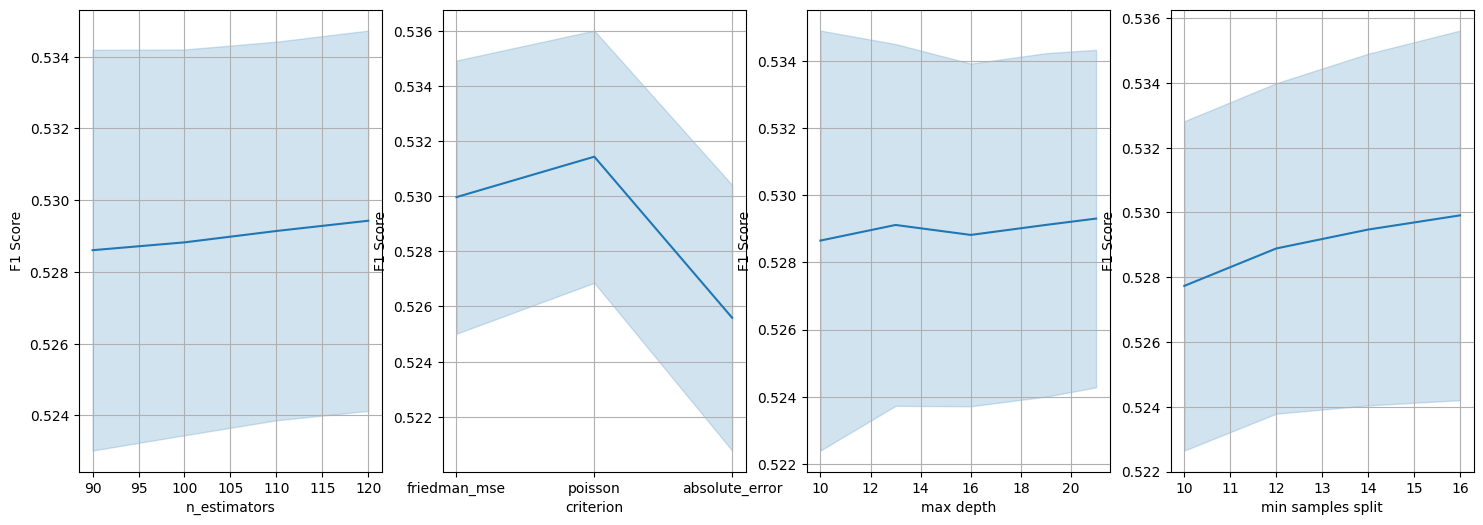

In [193]:
cv_results_df = pd.concat(cv_results_final_rfr, ignore_index=True)

plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1)
sb.lineplot(data=cv_results_df, x='param_n_estimators', y='mean_test_r2', estimator='mean', errorbar='sd')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.grid()

plt.subplot(1, 4, 2)
sb.lineplot(data=cv_results_df, x='param_criterion', y='mean_test_r2', estimator='mean', errorbar='sd')
plt.xlabel('criterion')
plt.ylabel('F1 Score')
plt.grid()

plt.subplot(1, 4, 3)
sb.lineplot(data=cv_results_df, x='param_max_depth', y='mean_test_r2', estimator='mean', errorbar='sd')
plt.xlabel('max depth')
plt.ylabel('F1 Score')
plt.grid()

plt.subplot(1, 4, 4)
sb.lineplot(data=cv_results_df, x='param_min_samples_split', y='mean_test_r2', estimator='mean', errorbar='sd')
plt.xlabel('min samples split')
plt.ylabel('F1 Score')
plt.grid()

# the five best models
the results were a bit mixed here too, but i think the most reacurring is: RandomForestRegressor(criterion='poisson', max_depth=21, min_samples_split=16, n_estimators=120)

In [194]:
for model in best_models_rfr:
    print(model)

RandomForestRegressor(criterion='poisson', max_depth=10, min_samples_split=16,
                      n_estimators=120)
RandomForestRegressor(criterion='poisson', max_depth=21, min_samples_split=16,
                      n_estimators=120)
RandomForestRegressor(criterion='absolute_error', max_depth=21,
                      min_samples_split=16, n_estimators=110)
RandomForestRegressor(criterion='poisson', max_depth=10, min_samples_split=10,
                      n_estimators=90)
RandomForestRegressor(criterion='poisson', max_depth=13, min_samples_split=14)


# Linear regressor elasticNet with original data and more parameters

In [ ]:
lr_params = {
    'alpha': [0.001, 0.01, 0.1], 
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  
}
best_models_lr, cv_results_lr, model_scores_lr = find_best_models(ElasticNet(), lr_params)

From the parameters I tested, I either saw a clear peak in the range or just a stable line. The F1 score drops significantly as alpha increases, while l1_ratio doesn’t seem to change much even when it's higher.

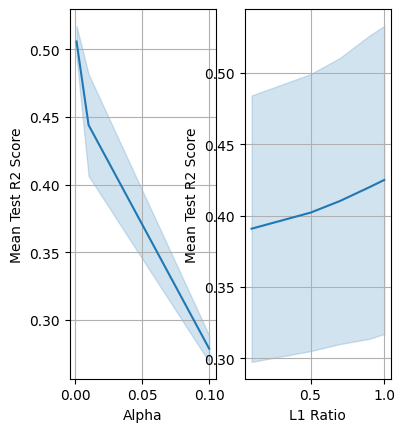

In [199]:
cv_results_lr = pd.concat(cv_results_lr, ignore_index=True)

plt.subplot(1, 3, 1)
sb.lineplot(data=cv_results_lr, x='param_alpha', y='mean_test_r2', estimator='mean', errorbar='sd')
plt.xlabel('Alpha') 
plt.ylabel('Mean Test R2 Score')
plt.grid()

plt.subplot(1, 3, 2)
sb.lineplot(data=cv_results_lr, x='param_l1_ratio', y='mean_test_r2', estimator='mean', errorbar='sd')
plt.xlabel('L1 Ratio') 
plt.ylabel('Mean Test R2 Score')
plt.grid()

# the five best models
We can see that the best model is 

In [363]:
print(best_models_lr)

[Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipelin

# final evaluation
after finding the best number of parameters i will evaluate the best models:

# the five best models of each model type

In [200]:
print("random forest regressor with original data")
print(model_scores_rfr)
print("Linear regressor elasticNet with original data")
print(model_scores_lr)

random forest regressor with original data
{'r2': [0.4879621997493375, 0.5653774120732467, 0.5332135089916179, 0.5648951885823501, 0.5771913252931109], 'mean_absolute_error': [1.6353273958362073, 1.4184077616573865, 1.4954885683179096, 1.5239427094633384, 1.5058204460429987], 'mean_squared_error': [5.851378792211083, 3.9644214134007587, 4.735905162814866, 4.52434254118979, 4.073605959192146]}
Linear regressor elasticNet with original data
{'r2': [0.4339205584291721, 0.49535458485527073, 0.5046659984262526, 0.5179015170655036, 0.5749008548506743], 'mean_absolute_error': [1.7599207835025266, 1.5672550423526572, 1.5957700532751784, 1.6470089160960364, 1.511025474670647], 'mean_squared_error': [6.468946701772239, 4.603136481050646, 5.025541442519452, 5.012995991188719, 4.095673798860128]}


In [201]:
print("random forest regressor with original data: ")
forest_best = RandomForestRegressor(criterion='poisson', max_depth=10, min_samples_split=21,
                      n_estimators=120).fit(train_val_features, train_val_targets)
print(evaluate(forest_best, test_features, test_targets))
print()

print("Linear regressor elasticNet with original data: ")
elasticnet_best = ElasticNet(alpha=0.001, l1_ratio=1.0).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_best, test_features, test_targets))
print()



random forest regressor with original data: 
{'r2': 0.6003651866256535, 'mean_absolute_error': 1.5275896677211083, 'mean_squared_error': 4.524266513594218}

Linear regressor elasticNet with original data: 
{'r2': 0.5582382561947027, 'mean_absolute_error': 1.6525440644050602, 'mean_squared_error': 5.0011855764255415}



# Visualling the results

# random forest regressor with original data

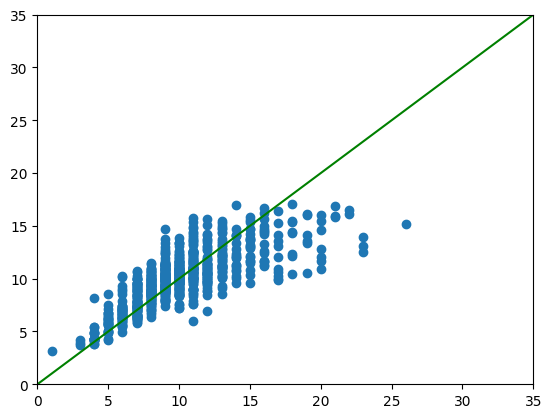

In [202]:
plt.scatter(test_targets, forest_best.predict(test_features))
plt.plot([0, 35], [0, 35], c='green')
plt.axis((0, 35, 0, 35))
plt.show()

# Linear regressor elasticNet with original data

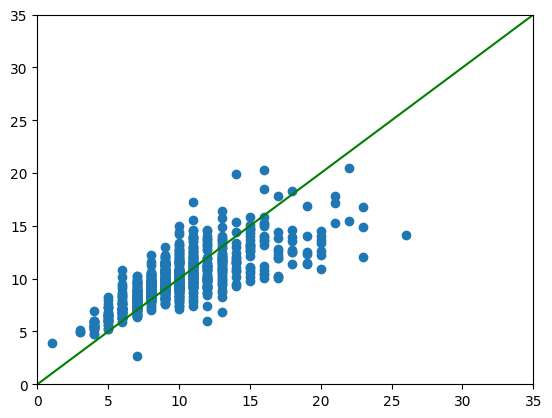

In [203]:
plt.scatter(test_targets, elasticnet_best.predict(test_features))
plt.plot([0, 35], [0, 35], c='green')
plt.axis((0, 35, 0, 35))
plt.show()

# Conclusion
Discussing the results from round one:  
Many of the results were quite similar. The modified dataset, which included dimensionality reduction, did not improve the performance of most models. This suggests that dimensionality reduction may not have been the best approach for this dataset, even though there was a high correlation between the features. As mentioned earlier, the best-performing models were the Random Forest Regressor and ElasticNet, with the Decision Tree model on the altered data performing almost as well. The worst performer was the combined model, which involved an SVR and Decision Tree together. This combination didn't work as effectively as expected, showing that combining models is not always necessary for better performance  

five best models from each model type from round two:  
The Random Forest Regressor with the original data consistently achieved the best scores across all iterations, suggesting that, on average, it outperformed ElasticNet. This indicates that for this particular dataset, the Random Forest model was more effective in capturing the underlying patterns.
   
metric from the two final best models:  
The Random Forest Regressor model had a higher R² than ElasticNet, indicating that it could explain more of the variance in the data. Additionally, the Decision Tree showed both lower MAE and lower MSE, suggesting that it made fewer and smaller errors in its predictions, performing better overall in terms of accuracy

visuall results from the two final best models:  
At first glance, the two graphs look very similar. Both scatter plots show a tight clustering of data points around the green regression line, suggesting that both models fit the data well. The spread of the points appears consistent, with no major outliers in either graph. While there are small differences between the models, it’s difficult to definitively determine which one is better based on these visuals alone

The best model is:
The Random Forest Regressor with orignal dataset, it had the best overall metrics and showed good results on the graph.
  
    
Things to consider:  
Hyperparameter Search Space: While we tuned the models using specific parameters, there could still be better configurations beyond the range we tested. Exploring a larger search space might uncover new peaks, leading to improved model performance. it was hard testing a very wide range of paramters without getting a too high run time, so i tested different intervals until i found an appropriate one.  
    
Small differences in results: The models didn’t show huge differences in their performance, so it’s possible that with a different test set or dataset, we might see a different "best" model. This just means that the results might vary depending on the data we’re working with.


# Sourced
Scikit-learn. (2024). SVR. Retrieved from https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVR.html
  
Scikit-learn. (2024). RandomForestRegressor. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html
  
Scikit-learn. (2024). ElasticNet. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.ElasticNet.html
  
StackOverflow: Precision Calculation Warning
StackOverflow. (2020, May 13). Precision calculation warning when using GridSearchCV for logistic regression. Retrieved from https://stackoverflow.com/questions/66538197/precision-calculation-warning-when-using-gridsearchcv-for-logistic-regression
   
Scikit-learn Documentation: StandardScaler
Scikit-learn. (2024). StandardScaler. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html
   
Scikit-learn Documentation: Pipeline
Scikit-learn. (2024). Pipeline. Retrieved from https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html
  
Scikit-learn. (2024). GridSearchCV. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html
  
